In [40]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import pandas as pd
import random

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam


from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()
    ax2.plot(history['accuracy'], label='Training accuracy')
    ax2.plot(history['val_accuracy'], label='Validation accuracy')
    ax2.legend()

    plt.show()

def plot_resultados(model, carpeta, height=64, width=64, n=4):
    """
    Muestra comparaciones entre imágenes originales y reconstruidas por el autoencoder.
    """
    # Seleccionar imágenes aleatorias
    archivos = os.listdir(carpeta)
    archivos_img = random.sample(archivos, n)

    # Cargar y normalizar las imágenes
    imgs_originales = []
    for nombre in archivos_img:
        img = load_img(os.path.join(carpeta, nombre), target_size=(height, width))
        img_array = img_to_array(img) / 255.0  # normalizar a [0,1]
        imgs_originales.append(img_array)

    imgs_originales = np.array(imgs_originales)

    # Reconstruir con el modelo
    imgs_reconstruidas = model.predict(imgs_originales)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs_originales[i])
        ax.set_title("Original")
        ax.axis("off")

        # Imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs_reconstruidas[i])
        ax.set_title("Reconstruida")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# VAE

## Defining Hiperparameters

In [41]:
import os

os.listdir("/kaggle/input")

['images']

In [42]:
height, width = 64, 64 # Image size, to fit in the competition size
image_dir = '/kaggle/input'

In [43]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        sigma = tf.exp(0.5 * log_var)
        epsilon = tf.random.normal(shape=tf.shape(mu))
        return mu + sigma * epsilon


In [44]:
input_img = keras.Input(shape=(height, width, 3))

# Encoder
x_enc = Conv2D(16, (3, 3), activation="relu", strides=2, padding="same")(input_img)
x_enc = Conv2D(32, (3, 3), activation="relu", strides=2, padding="same")(x_enc)
x_enc = Conv2D(64, (3, 3), activation="relu", strides=2, padding="same")(x_enc)
x_enc = Conv2D(128, (3, 3), activation="relu", strides=2, padding="same")(x_enc)
x_enc = Conv2D(128, (3, 3), activation="relu", strides=2, padding="same")(x_enc)
x_enc = Conv2D(256, (3, 3), activation="relu", strides=2, padding="same")(x_enc)
shape_before_flattening = keras.backend.int_shape(x_enc)[1:]
x_enc = Flatten()(x_enc)
x_enc = Dense(2048, activation="relu")(x_enc)
x_enc = Dense(1024, activation="relu")(x_enc)

# VAE: media y log-varianza
latent_dim = 1024
mu = Dense(latent_dim, name="mu")(x_enc)
log_var = Dense(latent_dim, name="log_var")(x_enc)

# Muestreo
z = Sampling()([mu, log_var])


# Decoder
x_dec = Dense(np.prod(shape_before_flattening), activation="relu")(z)
x_dec = Reshape(shape_before_flattening)(x_dec)
x_dec = Conv2DTranspose(256, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
x_dec = Conv2DTranspose(128, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
x_dec = Conv2DTranspose(128, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
x_dec = Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
x_dec = Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
x_dec = Conv2DTranspose(16, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x_dec)

We define the autoencoder, encoder and decoder

In [45]:
vae = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, z)
decoder = keras.Model(z, decoded)

vae.summary()

In [46]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer=opt, loss="mse", metrics = ['accuracy'])

## ImageDataGenerator

To fit with the competition, we will reshape images to 64x64

In [47]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create training and validation generators using the same seed
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),  
    batch_size=256,
    class_mode='input',
    subset='training',
    shuffle=True,
    seed=2004  
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),
    batch_size=256,
    class_mode='input',
    subset='validation',
    shuffle=False,
    seed=2004
)

Found 50852 images belonging to 1 classes.
Found 12713 images belonging to 1 classes.


## Train

In [48]:
# Fit the autoencoder
h = vae.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 108s 485ms/step - accuracy: 0.7017 - loss: 0.0743 - val_accuracy: 0.7424 - val_loss: 0.0501
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 91s 457ms/step - accuracy: 0.7438 - loss: 0.0465 - val_accuracy: 0.7427 - val_loss: 0.0483
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 93s 468ms/step - accuracy: 0.7442 - loss: 0.0432 - val_accuracy: 0.7375 - val_loss: 0.0438
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 91s 458ms/step - accuracy: 0.7395 - loss: 0.0410 - val_accuracy: 0.7438 - val_loss: 0.0418
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 94s 472ms/step - accuracy: 0.7779 - loss: 0.0385 - val_accuracy: 0.8260 - val_loss: 0.0387
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 114s 574ms/step - accuracy: 0.8313 - loss: 0.0356 - val_accuracy: 0.8406 - val_loss: 0.0366
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 118s 591ms/step - accuracy: 0.8419 - loss: 0.0345 - val_accuracy: 0.8453 - val_loss: 0.0358
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 103s 517ms/step - accuracy: 0.8399 - los

KeyboardInterrupt: 

In [ ]:
plot_losses(h.history)

In [49]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)
model_path = f"models/VAE_{timestamp}.keras"

# Save the model
vae.save(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


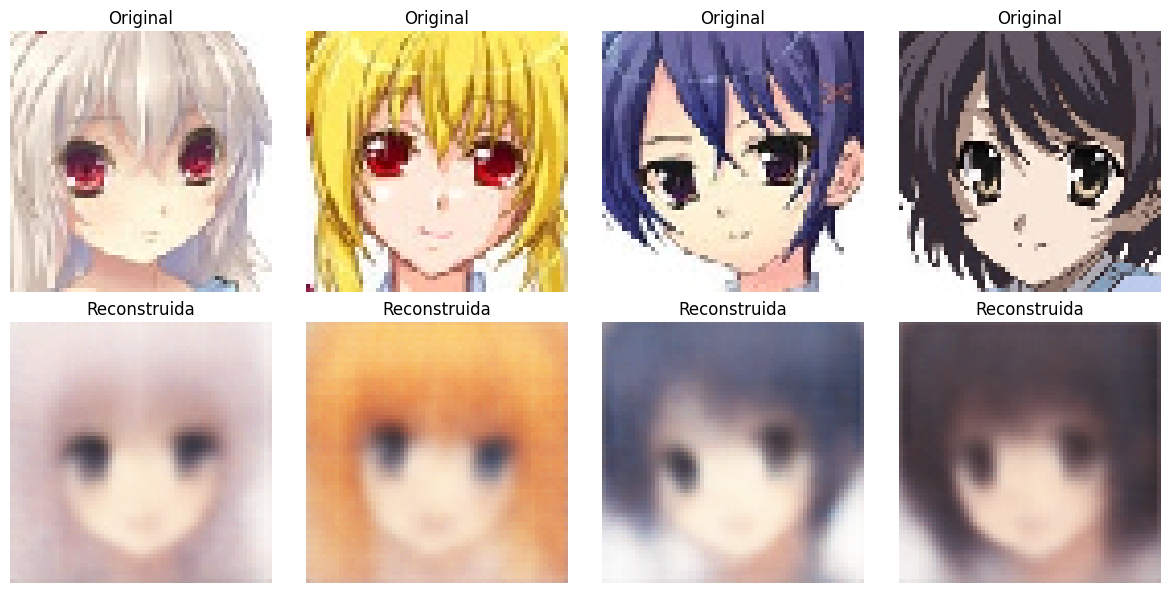

In [52]:
plot_resultados(vae, "/kaggle/input/images")